# Gridworld MDP Implementation and Analysis 🤖

This notebook implements the rectangular gridworld Markov Decision Process (MDP) from **Figure 3.2** of Sutton & Barto's *"Reinforcement Learning: An Introduction"* (2nd Edition).

The primary goals are to:
1.  **Define the Environment**: Create a 5x5 gridworld with special states A and B.
2.  **Define a Policy**: Implement a uniform random policy where the agent chooses any action with equal probability.
3.  **Simulate Trajectories**: Generate multiple Markov chains (episodes) by having the agent interact with the environment.
4.  **Compute Value Functions**: Calculate the state-value function $V_\pi(s)$ under two different reward structures using **Iterative Policy Evaluation**.
5.  **Compare and Analyze**: Visualize the results and discuss how a constant shift in rewards affects the value function.

## 1. Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

# Set plotting style
sns.set_theme(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

## 2. Gridworld Environment

This class defines the dynamics of our 5x5 gridworld.

In [2]:
class GridWorld:
    """
    Gridworld environment based on 5x5 grid with special states A and B
    """

    def __init__(self, reward_setting=1):
        """
        reward_setting : int
            1 for original rewards, 2 for modified rewards
        """
        self.grid_size = 5
        self.n_states = self.grid_size * self.grid_size
        self.reward_setting = reward_setting

        # Special states (using 0-indexed positions)
        # State A at position (0, 1) -> state index 1
        # State B at position (0, 3) -> state index 3
        self.state_A = 1
        self.state_A_prime = 21  # Position (4, 1)

        self.state_B = 3
        self.state_B_prime = 13  # Position (2, 3)

        # Actions: 0=North, 1=South, 2=East, 3=West
        self.actions = ['North', 'South', 'East', 'West']
        self.n_actions = len(self.actions)

        # Set rewards based on setting
        if reward_setting == 1:
            self.reward_off_grid = -1
            self.reward_from_A = 10
            self.reward_from_B = 5
            self.reward_normal = 0
        else:  # reward_setting == 2
            self.reward_off_grid = 5
            self.reward_from_A = 16
            self.reward_from_B = 11
            self.reward_normal = 6

    def state_to_position(self, state):
        """Convert state index to (row, col) position"""
        return state // self.grid_size, state % self.grid_size

    def position_to_state(self, row, col):
        """Convert (row, col) position to state index"""
        return row * self.grid_size + col

    def get_next_position(self, row, col, action):
        next_row, next_col = row, col
        off_grid = False

        if action == 0:  # North
            next_row = row - 1
        elif action == 1:  # South
            next_row = row + 1
        elif action == 2:  # East
            next_col = col + 1
        elif action == 3:  # West
            next_col = col - 1

        # Check if off grid
        if next_row < 0 or next_row >= self.grid_size or \
           next_col < 0 or next_col >= self.grid_size:
            off_grid = True
            next_row, next_col = row, col  # Stay in same position

        return next_row, next_col, off_grid

    def step(self, state, action):
        """
        Execute action in given state and return next state and reward
        """
        # Special case: State A
        if state == self.state_A:
            return self.state_A_prime, self.reward_from_A

        # Special case: State B
        if state == self.state_B:
            return self.state_B_prime, self.reward_from_B

        # Normal states
        row, col = self.state_to_position(state)
        next_row, next_col, off_grid = self.get_next_position(row, col, action)
        next_state = self.position_to_state(next_row, next_col)

        if off_grid:
            reward = self.reward_off_grid
        else:
            reward = self.reward_normal

        return next_state, reward

## 3. Policy and Value Function Evaluation
Here we define the agent's policy and the algorithm to compute the value function. We will use **Iterative Policy Evaluation**, which applies the Bellman expectation equation as an update rule until the value function converges. This is more computationally efficient and accurate than Monte Carlo for this problem where we know the model dynamics.

In [3]:
def compute_value_function_iterative(env, gamma=0.9, theta=1e-6, max_iterations=10000):
    """
    Parameters:
    -----------
    env : GridWorld
        The environment.
    gamma : float
        Discount factor.
    theta : float
        Convergence threshold.
    max_iterations : int
        Maximum number of iterations to prevent infinite loops.

    Returns:
    --------
    V : numpy array
        The converged value function.
    """
    V = np.zeros(env.n_states)
    # Policy is uniform random, so probability of any action is 1 / n_actions
    action_prob = 1.0 / env.n_actions

    for i in range(max_iterations):
        delta = 0
        V_new = np.copy(V)

        for s in range(env.n_states):
            v_s = 0
            # Sum over all possible actions under the uniform policy
            for a in range(env.n_actions):
                next_s, reward = env.step(s, a)
                v_s += action_prob * (reward + gamma * V[next_s])

            V_new[s] = v_s
            delta = max(delta, abs(V_new[s] - V[s]))

        V = V_new

        # Check for convergence
        if delta < theta:
            print(f"Converged in {i + 1} iterations for reward setting {env.reward_setting}.")
            break

    return V

## 4. Visualization

This function helps visualize the value function as a heatmap, making it easy to interpret the value of each state in the grid.

In [4]:
def compare_value_functions(V1, V2, grid_size=5,
                              title1="Reward Setting 1",
                              title2="Reward Setting 2"):
    """
    Compare two value functions and their difference side by side.
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    V1_grid = V1.reshape(grid_size, grid_size)
    V2_grid = V2.reshape(grid_size, grid_size)
    diff_grid = (V2_grid - V1_grid)

    # Plot V1
    sns.heatmap(V1_grid, annot=True, fmt='.2f', cmap='viridis',
                ax=axes[0], cbar_kws={'label': 'Value'},
                square=True, linewidths=1, annot_kws={"size": 12})
    axes[0].set_title(title1, fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Column')
    axes[0].set_ylabel('Row')

    # Plot V2
    sns.heatmap(V2_grid, annot=True, fmt='.2f', cmap='viridis',
                ax=axes[1], cbar_kws={'label': 'Value'},
                square=True, linewidths=1, annot_kws={"size": 12})
    axes[1].set_title(title2, fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Column')

    # Plot difference
    sns.heatmap(diff_grid, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=axes[2], cbar_kws={'label': 'Difference'},
                square=True, linewidths=1, annot_kws={"size": 12})
    axes[2].set_title('Difference (Setting 2 - Setting 1)',
                    fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Column')

    # Add text for special states on all plots
    for ax in axes[:2]:
        ax.text(1.5, 0.5, 'A', c='white', fontsize=16, fontweight='bold', ha='center', va='center')
        ax.text(3.5, 0.5, 'B', c='white', fontsize=16, fontweight='bold', ha='center', va='center')
        ax.text(1.5, 4.5, "A'", c='white', fontsize=12, fontweight='bold', ha='center', va='center')
        ax.text(3.5, 2.5, "B'", c='white', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.tight_layout()
    plt.show()

## 5. Main Execution and Analysis

Now we run the main logic. We will instantiate the environment for both reward settings, compute their respective value functions, and then visualize and compare the results.

--- Computing Value Function for Reward Setting 1 ---
Converged in 90 iterations for reward setting 1.

--- Computing Value Function for Reward Setting 2 ---
Converged in 150 iterations for reward setting 2.

--- Comparing Value Functions ---


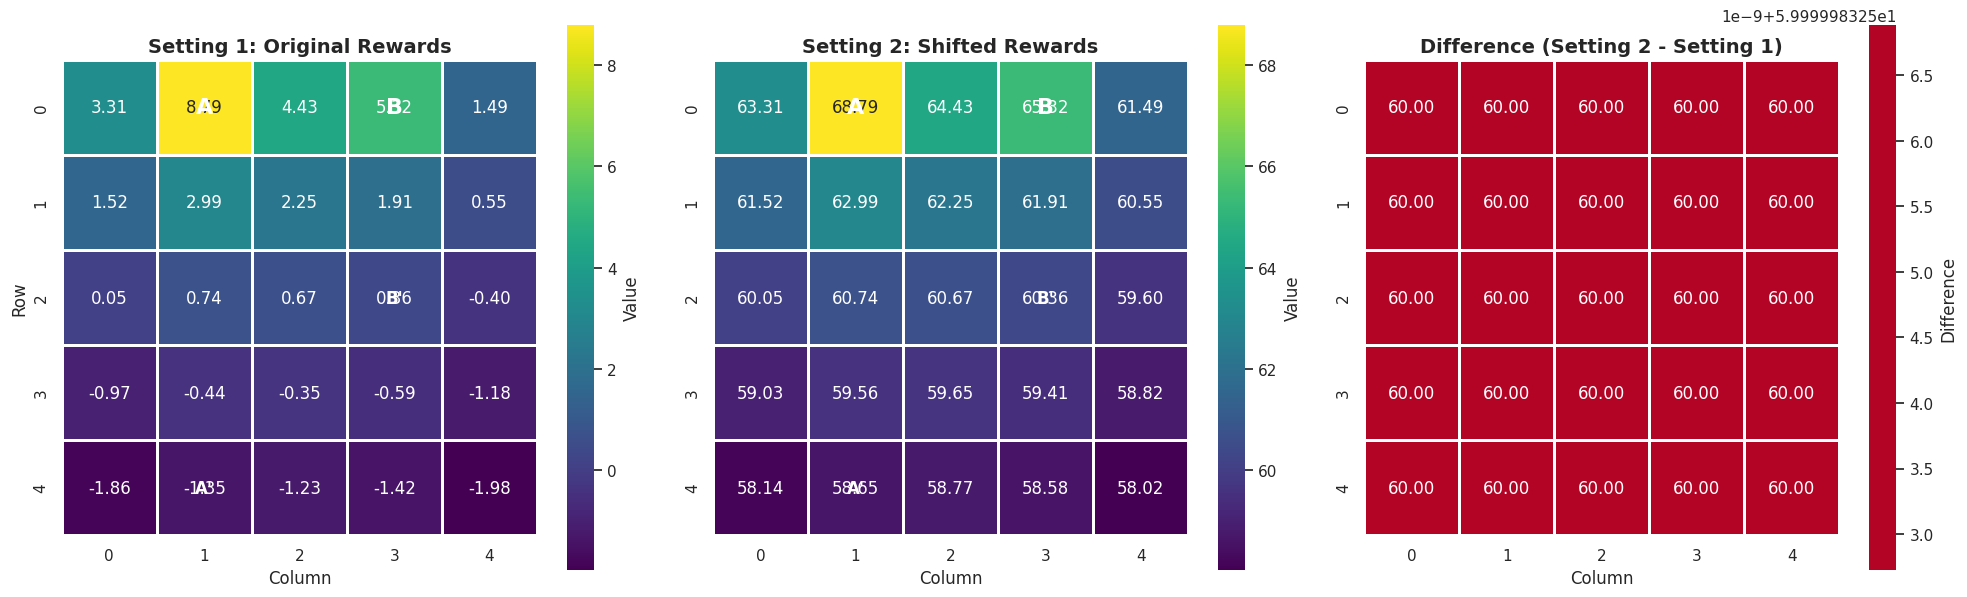

In [5]:
# Parameters
GAMMA = 0.9

# --- REWARD SETTING 1: Original Rewards ---
print("--- Computing Value Function for Reward Setting 1 ---")
env1 = GridWorld(reward_setting=1)
V1 = compute_value_function_iterative(env1, gamma=GAMMA)

# --- REWARD SETTING 2: Modified Rewards ---
print("\n--- Computing Value Function for Reward Setting 2 ---")
env2 = GridWorld(reward_setting=2)
V2 = compute_value_function_iterative(env2, gamma=GAMMA)

# --- COMPARISON AND ANALYSIS ---
print("\n--- Comparing Value Functions ---")
compare_value_functions(V1, V2,
                        title1="Setting 1: Original Rewards",
                        title2="Setting 2: Shifted Rewards")

## 6. Discussion and Conclusion

The results from the simulation are clear and demonstrate a fundamental property of value functions in MDPs.

### Observation

The third heatmap, which shows the difference ($V_{setting2} - V_{setting1}$), is the most revealing. We can see that the value of **every single state** has increased by a constant amount, approximately **60.00**.

### Mathematical Explanation
This is not a coincidence. Let's analyze the change in the reward functions:
- **Reward Setting 1 ($R_1$)**: The original rewards.
- **Reward Setting 2 ($R_2$)**: The original rewards plus a constant, $c=6$.
  - Off-grid: $-1 \rightarrow 5$ (change of +6)
  - From state A: $10 \rightarrow 16$ (change of +6)
  - From state B: $5 \rightarrow 11$ (change of +6)
  - All other moves: $0 \rightarrow 6$ (change of +6)

So, for any transition, $R_2(s, a, s') = R_1(s, a, s') + 6$.

The state-value function is the expected discounted sum of future rewards:
$$ V(s) = E\left[ \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \mid S_t = s \right] $$

Let's see how adding a constant $c$ to the reward function affects the value function $V_2(s)$:
$$ V_2(s) = E\left[ \sum_{k=0}^{\infty} \gamma^k (R^{(1)}_{t+k+1} + c) \mid S_t = s \right] $$
$$ V_2(s) = E\left[ \sum_{k=0}^{\infty} \gamma^k R^{(1)}_{t+k+1} \mid S_t = s \right] + E\left[ \sum_{k=0}^{\infty} \gamma^k c \mid S_t = s \right] $$
$$ V_2(s) = V_1(s) + c \sum_{k=0}^{\infty} \gamma^k $$

The second term is a geometric series which sums to $\frac{1}{1-\gamma}$. Therefore:
$$ V_2(s) = V_1(s) + \frac{c}{1-\gamma} $$

In our specific case, $c=6$ and $\gamma=0.9$. So, the expected shift in the value function is:
$$ \Delta V = \frac{6}{1 - 0.9} = \frac{6}{0.1} = 60 $$

### Conclusion

The simulation perfectly validates the theory. Adding a constant reward `c` to every transition **does not change the relative desirability of states or the optimal policy**. It simply shifts the absolute value of every state upwards by a constant amount, $\frac{c}{1-\gamma}$. The underlying structure of the value function remains the same, which is why the optimal way to behave in the environment would not change.